# Project 4: Autoencoder - How many units?

### Brief Project Description

In this project, our goal is to create a deep learning model with an autoencoder architecture. Additionally, we conduct a parametric experiment to answer the question: What is the optimal combination of encoding/decoding units and latent units within a specified range, aiming for minimal loss?

The range for the encoding/decoding units and latent units is defined as following:
- **Encoding/decoding units: [100, 500] in 12 steps.**
- **Latent units: [5, 100] in 8 steps.**

After conducting the experiment, we visualize and evaluate the obtained results.

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import sys

## Import and Process the Data

In [79]:
# import dataset 
data = np.loadtxt(open('/home/marvin/Downloads/mnist_train_small.csv'),delimiter=',')

# don't need labels]
data = data[:,1:]

# normalize the data to a range of [0,1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor(dataNorm).float()

## Create the Model

In [80]:
# create a class for the model

def createTheMNISTAE(encodingUnits, latUnits):
    
    class AEnet(nn.Module):
        
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(784,encodingUnits)
            
            ### encoder layer
            self.enc = nn.Linear(encodingUnits, latUnits)
            
            ### latent layer
            self.lat = nn.Linear(latUnits, encodingUnits)
            
            ### decoder layer
            self.dec = nn.Linear(encodingUnits, 784)
        
        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.enc(x) )
            x = F.relu( self.lat(x) )
            return torch.sigmoid( self.dec(x) )
        
    # create a model instance
    net = AEnet()
    
    # lossfunction
    lossfun = nn.MSELoss()
    
    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    
    return net, lossfun, optimizer

In [81]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE(250,50)

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


## Train The Model

Notice that for the sake of coding, we are not using PyTorch DataLoader objects to create minibatches. Instead, we write code to generate minibatches ourselves.

In [82]:
def trainTheModel(encodingUnits, latUnits):
    
    # number of epochs
    numepochs = 1000
    
    # create a new model
    net, lossfun, optimizer = createTheMNISTAE(encodingUnits, latUnits)
    
    # initialize losses
    losses = torch.zeros(numepochs)
    data4batches = copy.deepcopy(dataT)
    
    # loop over epochs
    for epochi in range(numepochs):
        
        """
        We have a total of dataT.shape[0] images, and each batch consists of 32 images. 
        This implies that after dataT.shape[0]/32 epochs, we need to resample our image 
        data to ensure that each image occurs exactly once within that number of epochs. 
        The logic for implementing this resampling is captured in the following if-statement.
        """
        
        # initialize the input
        X = None
        
        if epochi % (dataT.shape[0]/32) != 0:
            
            # choose randomly 32 row indicies from data4batches
            randomidx = np.random.choice(data4batches.shape[0], size=32,replace=False)
            X = dataT[randomidx,:]
            
            # remove the rows for the minibatch from data4batches 
            data4batches = np.delete(data4batches, randomidx, axis=0)
        
        else:
            # create a new sample of dataT
            data4batches = copy.deepcopy(dataT)
            
            # choose randomly 32 row indicies from data4batches
            randomidx = np.random.choice(data4batches.shape[0], size=32,replace=False)
            X = dataT[randomidx,:]
            
            # remove the rows for the minibatch from data4batches 
            data4batches = np.delete(data4batches, randomidx, axis=0)
            
        # forwad pass and loss
        yHat = net(X)
        loss = lossfun(yHat,X)
        
        # backprob
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # losses in this epoch
        losses[epochi] = loss.item()
       # end epochs
    
    # function output
    return losses, net

## Run the Experiment

In [83]:
# initialize array for the different encoding/decoding units
encodingUnitsList = np.linspace(10,500,12, dtype=int)

# initialize array for the different latent units
latUnitsList = np.linspace(5,100,8,dtype=int)

# initialize a matric, where we store the losses
results = np.zeros((len(encodingUnitsList),len(latUnitsList)))

# initialize a variable that reports the current experiment number
experimentNumber = 0

# loop over the encoding/decoding unit list
for idxencodingUnit, encodingUnit in enumerate(encodingUnitsList):
    
    # loop over the latent unit list
    for idxlatUnit, latUnit in enumerate(latUnitsList):
        losses = trainTheModel(encodingUnit, latUnit)[0]
        results[idxencodingUnit, idxlatUnit] = torch.mean(losses[-5:]).item()
        
        # send an update massage
        experimentNumber += 1
        totalExperimentLength = len(encodingUnitsList)*len(latUnitsList)
        updateStringMassage = 'Finished Experiment {}/{}'.format(experimentNumber, totalExperimentLength)
        sys.stdout.write('\r' +updateStringMassage )
        
   

Finished Experiment 96/96

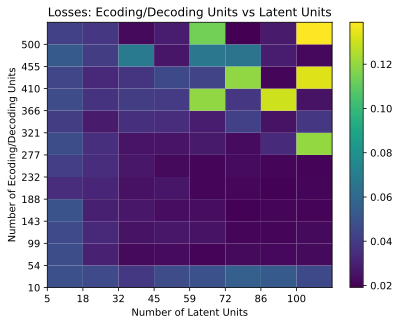

For 500 ecoding/decoding units and 72 latent units, we achieved the lowest loss, which is 0.019.


In [87]:
# print the results
pc = plt.pcolormesh(results)

plt.title('Losses: Ecoding/Decoding Units vs Latent Units')
plt.yticks(range(12), labels=encodingUnitsList)
plt.xticks(range(8), labels=latUnitsList)
plt.ylabel('Number of Ecoding/Decoding Units')
plt.xlabel('Number of Latent Units')

plt.colorbar(pc)
plt.show()

# print out the comination with the lowest loss
np.argmin(results)
ind = np.unravel_index(np.argmin(results, axis=None), results.shape)

print(f'For {encodingUnitsList[ind[0]]} ecoding/decoding units and {latUnitsList[ind[1]]} \
latent units, we achieved the lowest loss, which is {np.min(results):.3f}.')

## References:

https://www.udemy.com/course/deeplearning_x/